# Results on ENCODE ChIP-seq data using JASPAR2014 binding profiles for ChIP'ed TFs
1st and 2nd order DNA shape features were used. PSSMs were optimized using DiMO.

## Data sets

In [1]:
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
from matplotlib.pyplot import savefig
import pandas as pd
import numpy as np
data = pd.read_csv("data/20150317/wgEncodeAwgTfbs_with_JASPAR_MA.csv", header=0, index_col=0,
                  names=["ENCODE_data_set", "TF_name", "JASPAR_id"])
print "{0:d} ENCODE experiments are considered here (i.e. associated to a JASPAR profile).".format(len(data))
print "It corresponds to {0:d} different TFs.".format(len(set(data["TF_name"])))

400 ENCODE experiments are considered here (i.e. associated to a JASPAR profile).
It corresponds to 76 different TFs.


In [2]:
from Bio.motifs.jaspar.db import JASPAR5
# Put the hostname of your local JASPAR database (2014 version was used in our ms)
# along with name, user, and password to access it
jdb = JASPAR5(host='', name='', user='', password='')

In [3]:
def get_tf_family(jasparid):
    motif = jdb.fetch_motif_by_id(jasparid)
    return motif.tf_family

In [4]:
data["TF_family"] = data["JASPAR_id"].map(get_tf_family)

In [5]:
def rename_tf_fam(name):
    if name == "BetaBetaAlpha-zinc finger":
        return "BetaBetaAlpha-zinc Finger"
    elif name == "Ets":
        return "ETS"
    elif name == "Homeo":
        return "Homeodomain"
    elif name == "Leucine-Zipper":
        return "Leucine Zipper"
    elif name == "NF-Y CCAAT-Binding":
        return "NFY CCAAT-binding"
    else:
        return name

In [6]:
print "The number of ChIP-seq experiments associated to each TF family is given below:"
families = {}
for family in data["TF_family"].map(rename_tf_fam):
    if family in families:
        families[family]["all TFs # occurences"] += 1
    else:
        families[family] = {}
        families[family]["all TFs # occurences"] = 1
all_tf_fam_df = pd.DataFrame.from_dict(families, orient='index')
all_tf_fam_df.sort("all TFs # occurences", ascending=False)

The number of ChIP-seq experiments associated to each TF family is given below:


all TFs # occurences
BetaBetaAlpha-zinc Finger                   146
Helix-Loop-Helix                             56
Leucine Zipper                               55
ETS                                          21
Stat                                         13
GATA                                         12
Rel                                          10
E2F                                          10
High Mobility Group (Box)                     8
Forkhead                                      8
Hormone-nuclear Receptor                      8
Homeodomain                                   7
MADS                                          7
NFY CCAAT-binding                             6
TATA-binding                                  5
NRF                                           5
RFX                                           5
STAT                                          4
IRF                                           4
Other                                         4
Arid                                          2
NFI CCAAT-binding                             2
HSF                                           1
THAP                                          1

In [7]:
print "TFs are coming from {0:d} different TF families.".format(len(families))

TFs are coming from 24 different TF families.


In [8]:
def auc_val(inline):
    return eval(inline.split(' ')[-1])

import os
rep = '20151103_JasparMatchedChipseqScaledDnashape2ndOrderDimo'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUROC'] = auc_val(first_line)
                second_line = stream.readline()
                assert second_line.startswith('PR AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUPRC'] = auc_val(second_line)
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC TFFM')
                data.loc[repo, 'TFFM_AUROC'] = auc_val(third_line)
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC TFFM')
                data.loc[repo, 'TFFM_AUPRC'] = auc_val(fourth_line)
                fifth_line = stream.readline()
                assert fifth_line.startswith('ROC AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUROC'] = auc_val(fifth_line)
                sixth_line = stream.readline()
                assert sixth_line.startswith('PR AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUPRC'] = auc_val(sixth_line)
                seventh_line = stream.readline()
                assert seventh_line.startswith('ROC AUC PWM')
                data.loc[repo, 'PSSM_AUROC'] = auc_val(seventh_line)
                eighth_line = stream.readline()
                assert eighth_line.startswith('PR AUC PWM')
                data.loc[repo, 'PSSM_AUPRC'] = auc_val(eighth_line)
                data.loc[repo, 'TFFM_AUROC_improvement'] = data.loc[repo, 'TFFM_dnashape_AUROC'] - data.loc[repo, 'TFFM_AUROC']
                data.loc[repo, 'TFFM_AUPRC_improvement'] = data.loc[repo, 'TFFM_dnashape_AUPRC'] - data.loc[repo, 'TFFM_AUPRC']
                data.loc[repo, 'PSSM_AUROC_improvement'] = data.loc[repo, 'PSSM_dnashape_AUROC'] - data.loc[repo, 'PSSM_AUROC']
                data.loc[repo, 'PSSM_AUPRC_improvement'] = data.loc[repo, 'PSSM_dnashape_AUPRC'] - data.loc[repo, 'PSSM_AUPRC']
data.TF_family = data.TF_family.map(rename_tf_fam)

## TFFM analyses


### Results on all the ChIP-seq experiments

In [9]:
print "TFFM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUROC"] > data["TFFM_AUROC"]]), len(data.dropna()))
print "TFFM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUPRC"] > data["TFFM_AUPRC"]]), len(data.dropna()))

TFFM-based classifiers have higher AUROC in 399 over 400 cases
TFFM-based classifiers have higher AUPRC in 396 over 400 cases


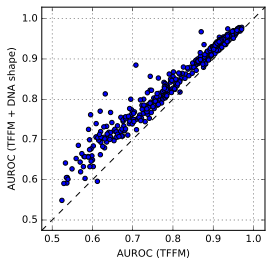

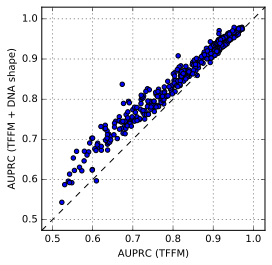

In [10]:
mini = min(min(data.dropna()["TFFM_AUROC"]), min(data.dropna()["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUROC"]), max(data.dropna()["TFFM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUROC", y="TFFM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_TFFM_TFFM+DNAshape.svg")

mini = min(min(data.dropna()["TFFM_AUPRC"]), min(data.dropna()["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUPRC"]), max(data.dropna()["TFFM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUPRC", y="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_TFFM_TFFM+DNAshape.svg")

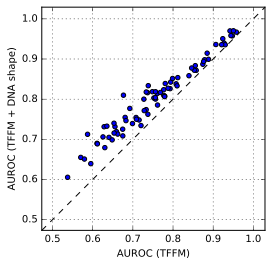

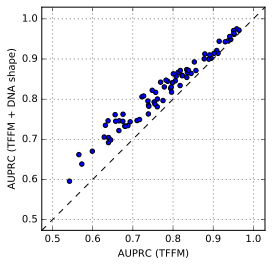

In [11]:
tf_dico = {'TF_name': [], 'TFFM_dnashape_AUROC': [], 'TFFM_AUROC': [],
           'TFFM_dnashape_AUPRC': [], 'TFFM_AUPRC': []}
for tf in list(set(data.TF_name)):
    tf_dico['TF_name'].append(tf)
    tf_dico['TFFM_dnashape_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_dnashape_AUROC.median())
    tf_dico['TFFM_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_AUROC.median())
    tf_dico['TFFM_dnashape_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_dnashape_AUPRC.median())
    tf_dico['TFFM_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_AUPRC.median())
data_tffm = pd.DataFrame(tf_dico)
axes = data_tffm.dropna().plot(x='TFFM_AUROC', y='TFFM_dnashape_AUROC', kind='scatter')
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig('AUROC_TFFM_TFFM+DNAshape_perTF.svg')

axes = data_tffm.dropna().plot(x='TFFM_AUPRC', y='TFFM_dnashape_AUPRC', kind='scatter')
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig('AUPRC_TFFM_TFFM+DNAshape_perTF.svg')

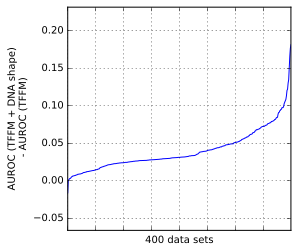

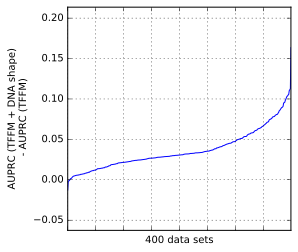

In [12]:
data = data.sort("TFFM_AUROC_improvement")
axes = data.dropna().plot(y="TFFM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (TFFM + DNA shape)\n - AUROC (TFFM)")
axes.set_ylim(min(data.TFFM_AUROC_improvement) - 0.05,
              max(data.TFFM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_TFFM_TFFM+DNAshape.svg")

data = data.sort("TFFM_AUPRC_improvement")
axes = data.dropna().plot(y="TFFM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (TFFM + DNA shape)\n - AUPRC (TFFM)")
axes.set_ylim(min(data.TFFM_AUPRC_improvement) - 0.05,
              max(data.TFFM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_TFFM_TFFM+DNAshape.svg")

In [13]:
print 'AUROC difference > 0.05 for {0:d} data sets'.format(
    len(data[data.TFFM_AUROC_improvement > 0.05]))
print 'AUPRC difference > 0.05 for {0:d} data sets'.format(
    len(data[data.TFFM_AUPRC_improvement > 0.05]))

AUROC difference > 0.05 for 103 data sets
AUPRC difference > 0.05 for 94 data sets


In [14]:
%load_ext rpy2.ipython

In [15]:
families_list = families.keys()

In [16]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'TFFM_AUROC_improvement'];
    outside = data[data['TF_family'] != family, 'TFFM_AUROC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [17]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort('mww_corrected')

mww_pval  mww_corrected
E2F                        0.000022       0.000530
MADS                       0.000048       0.001146
Homeodomain                0.000956       0.022943
Other                      0.002253       0.054061
TATA-binding               0.003105       0.074523
IRF                        0.003150       0.075591
RFX                        0.010067       0.241598
Rel                        0.019263       0.462305
NFI CCAAT-binding          0.034534       0.828825
High Mobility Group (Box)  0.035252       0.846043
Hormone-nuclear Receptor   0.045688       1.096504
THAP                       0.052673       1.264147
Forkhead                   0.066839       1.604142
HSF                        0.074051       1.777228
ETS                        0.085808       2.059388
GATA                       0.182380       4.377113
Arid                       0.197884       4.749218
STAT                       0.270704       6.496898
BetaBetaAlpha-zinc Finger  0.925761      22.218263
NRF                        0.968877      23.253040
Helix-Loop-Helix           0.976070      23.425673
NFY CCAAT-binding          0.981381      23.553155
Stat                       0.997223      23.933352
Leucine Zipper             1.000000      24.000000

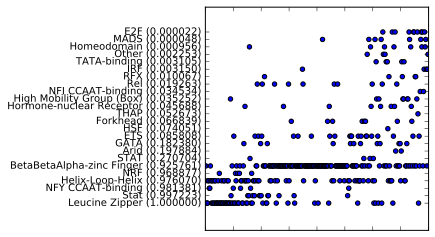

In [18]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
axes.set_xlim(0, len(data))
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
axes.set_aspect(1./axes.get_data_ratio())
axes.tick_params(axis="x", labelbottom='off')
#savefig("AUROC_improvement_TFFM_TFFM+DNAshape_families.svg")

In [19]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'TFFM_AUPRC_improvement'];
    outside = data[data['TF_family'] != family, 'TFFM_AUPRC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [20]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort('mww_corrected')

mww_pval  mww_corrected
E2F                        0.000002       0.000052
MADS                       0.002014       0.048329
High Mobility Group (Box)  0.003295       0.079087
Homeodomain                0.004720       0.113291
TATA-binding               0.004765       0.114356
IRF                        0.007332       0.175971
Other                      0.010439       0.250544
NFI CCAAT-binding          0.010486       0.251667
RFX                        0.017272       0.414534
Arid                       0.036451       0.874824
Forkhead                   0.038747       0.929930
THAP                       0.058498       1.403943
GATA                       0.065559       1.573407
Hormone-nuclear Receptor   0.065647       1.575524
ETS                        0.079602       1.910458
HSF                        0.135697       3.256739
BetaBetaAlpha-zinc Finger  0.237149       5.691585
STAT                       0.241352       5.792437
Rel                        0.418252      10.038041
NFY CCAAT-binding          0.995374      23.888979
NRF                        0.997372      23.936938
Stat                       0.997576      23.941815
Helix-Loop-Helix           0.998658      23.967801
Leucine Zipper             1.000000      24.000000

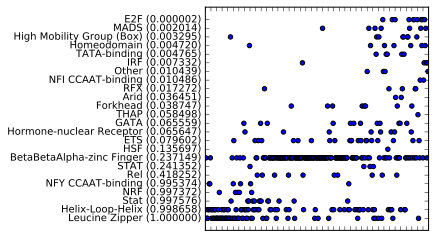

In [21]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
axes.set_xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_TFFM_TFFM+DNAshape_families.svg")

## PSSM analyses

### Results on all the ChIP-seq experiments

In [22]:
print "PSSM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUROC"] > data["PSSM_AUROC"]]), len(data.dropna()))
print "PSSM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUPRC"] > data["PSSM_AUPRC"]]), len(data.dropna()))

PSSM-based classifiers have higher AUROC in 400 over 400 cases
PSSM-based classifiers have higher AUPRC in 400 over 400 cases


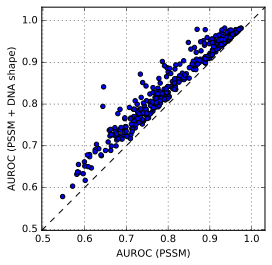

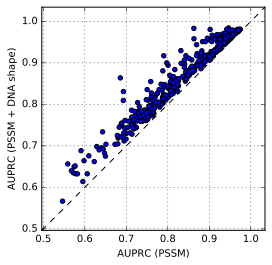

In [23]:
mini = min(min(data.dropna()["PSSM_AUROC"]), min(data.dropna()["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["PSSM_AUROC"]), max(data["PSSM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUROC", y="PSSM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_PSSM_PSSM+DNAshape.svg")

mini = min(min(data["PSSM_AUPRC"]), min(data["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["PSSM_AUPRC"]), max(data["PSSM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUPRC", y="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_PSSM_PSSM+DNAshape.svg")

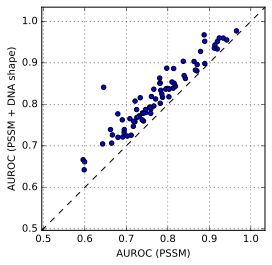

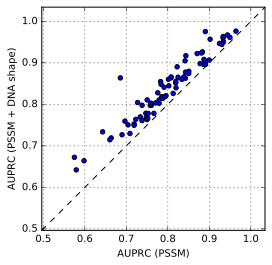

In [24]:
tf_dico = {'TF_name': [], 'PSSM_dnashape_AUROC': [], 'PSSM_AUROC': [],
          'PSSM_dnashape_AUPRC': [], 'PSSM_AUPRC': []}
for tf in list(set(data.TF_name)):
    tf_dico['TF_name'].append(tf)
    tf_dico['PSSM_dnashape_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_dnashape_AUROC.median())
    tf_dico['PSSM_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_AUROC.median())
    tf_dico['PSSM_dnashape_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_dnashape_AUPRC.median())
    tf_dico['PSSM_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_AUPRC.median())
data_pssm = pd.DataFrame(tf_dico)
axes = data_pssm.dropna().plot(x='PSSM_AUROC', y='PSSM_dnashape_AUROC', kind='scatter')
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig('AUROC_PSSM_PSSM+DNAshape_perTF.svg')

axes = data_pssm.dropna().plot(x='PSSM_AUPRC', y='PSSM_dnashape_AUPRC', kind='scatter')
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
#savefig('AUPRC_PSSM_PSSM+DNAshape_perTF.svg')

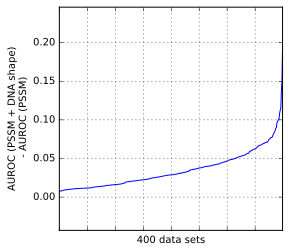

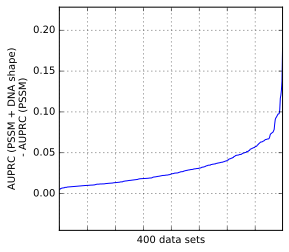

In [25]:
data = data.sort("PSSM_AUROC_improvement")
axes = data.dropna().plot(y="PSSM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (PSSM + DNA shape)\n - AUROC (PSSM)")
axes.set_ylim(min(data.PSSM_AUROC_improvement) - 0.05,
              max(data.PSSM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_PSSM_PSSM+DNAshape.svg")

data = data.sort("PSSM_AUPRC_improvement")
axes = data.dropna().plot(y="PSSM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (PSSM + DNA shape)\n - AUPRC (PSSM)")
axes.set_ylim(min(data.PSSM_AUPRC_improvement) - 0.05,
              max(data.PSSM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_PSSM_PSSM+DNAshape.svg")

In [26]:
print 'AUROC difference is > 0.05 for {0:d} data-sets.'.format(
    len(data[data.PSSM_AUROC_improvement > 0.05]))
print 'AUPRC difference is > 0.05 for {0:d} data-sets.'.format(
    len(data[data.PSSM_AUPRC_improvement > 0.05]))

AUROC difference is > 0.05 for 86 data-sets.
AUPRC difference is > 0.05 for 69 data-sets.


In [27]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'PSSM_AUROC_improvement'];
    outside = data[data['TF_family'] != family, 'PSSM_AUROC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [28]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort('mww_corrected')

mww_pval  mww_corrected
MADS                       0.000000       0.000009
Other                      0.001069       0.025649
Rel                        0.001612       0.038687
E2F                        0.002012       0.048291
NRF                        0.002201       0.052834
HSF                        0.002500       0.060000
TATA-binding               0.002799       0.067171
NFY CCAAT-binding          0.003650       0.087604
IRF                        0.004425       0.106191
Homeodomain                0.006295       0.151078
NFI CCAAT-binding          0.011654       0.279699
THAP                       0.050000       1.200000
RFX                        0.065010       1.560232
Hormone-nuclear Receptor   0.072070       1.729670
High Mobility Group (Box)  0.094108       2.258583
STAT                       0.123372       2.960937
Arid                       0.175965       4.223158
Leucine Zipper             0.353554       8.485291
Stat                       0.458720      11.009288
Forkhead                   0.566799      13.603181
Helix-Loop-Helix           0.905577      21.733849
ETS                        0.905661      21.735862
GATA                       0.980460      23.531031
BetaBetaAlpha-zinc Finger  1.000000      24.000000

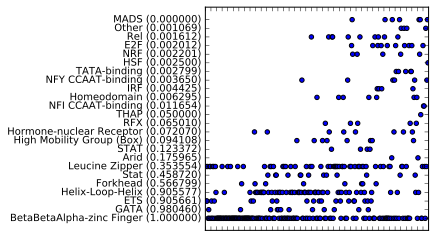

In [29]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_PSSM_PSSM+DNAshape_families.svg")

In [30]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'PSSM_AUPRC_improvement'];
    outside = data[data['TF_family'] != family, 'PSSM_AUPRC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [31]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort('mww_corrected')

mww_pval  mww_corrected
E2F                        0.000033       0.000786
MADS                       0.000086       0.002068
TATA-binding               0.000332       0.007978
Other                      0.000509       0.012212
NFI CCAAT-binding          0.000802       0.019248
HSF                        0.002500       0.060000
NFY CCAAT-binding          0.006561       0.157460
NRF                        0.009090       0.218162
IRF                        0.011444       0.274660
Homeodomain                0.016060       0.385448
Arid                       0.022105       0.530526
RFX                        0.026027       0.624642
Rel                        0.028769       0.690456
THAP                       0.035000       0.840000
High Mobility Group (Box)  0.103350       2.480395
Hormone-nuclear Receptor   0.107333       2.576002
STAT                       0.107838       2.588102
Stat                       0.382466       9.179179
Leucine Zipper             0.537415      12.897969
Forkhead                   0.548849      13.172369
GATA                       0.876823      21.043748
Helix-Loop-Helix           0.918711      22.049054
ETS                        0.942534      22.620820
BetaBetaAlpha-zinc Finger  1.000000      24.000000

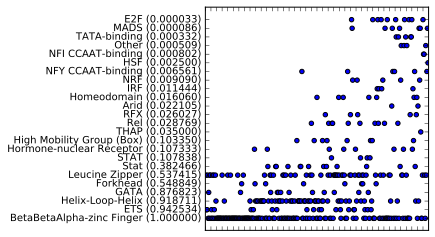

In [32]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_PSSM_PSSM+DNAshape_families.svg")

# Results considering TFBS flanking sequences

## TFFM results on all ChIP-seq experiments

In [33]:
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results_extension_15bp.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC TFFM')
                ext_tffm_dnashape_auc = eval(first_line.split(' ')[-1])
                data.loc[repo, "ext_TFFM_dnashape_AUROC"] = ext_tffm_dnashape_auc
                data.loc[repo, "ext_TFFM_dnashape_AUROC_improvement"] = ext_tffm_dnashape_auc - data["TFFM_dnashape_AUROC"][repo]
                second_line = stream.readline()
                assert second_line.startswith('PR AUC TFFM')
                ext_tffm_dnashape_auprc = eval(second_line.split(' ')[-1])
                data.loc[repo, "ext_TFFM_dnashape_AUPRC"] = ext_tffm_dnashape_auprc
                data.loc[repo, "ext_TFFM_dnashape_AUPRC_improvement"] = ext_tffm_dnashape_auprc - data["TFFM_dnashape_AUPRC"][repo]
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC PWM')
                ext_pwm_dnashape_auc = eval(third_line.split(' ')[-1])
                data.loc[repo, "ext_PSSM_dnashape_AUROC"] = ext_pwm_dnashape_auc
                data.loc[repo, "ext_PSSM_dnashape_AUROC_improvement"] = ext_pwm_dnashape_auc - data["PSSM_dnashape_AUROC"][repo]
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC PWM')
                ext_pwm_dnashape_auprc = eval(fourth_line.split(' ')[-1])
                data.loc[repo, 'ext_PSSM_dnashape_AUPRC'] = ext_pwm_dnashape_auprc
                data.loc[repo, 'ext_PSSM_dnashape_AUPRC_improvement'] = ext_pwm_dnashape_auprc - data['PSSM_dnashape_AUPRC'][repo]

In [34]:
print "TFFM-based classifier using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_TFFM_dnashape_AUROC"] > data["TFFM_dnashape_AUROC"]]), len(data.dropna()))
print "TFFM-based classifier using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_TFFM_dnashape_AUPRC"] > data["TFFM_dnashape_AUPRC"]]), len(data.dropna()))

TFFM-based classifier using the 15bp extension is superior in 384 over 400 cases
TFFM-based classifier using the 15bp extension is superior in 373 over 400 cases


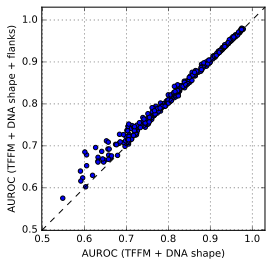

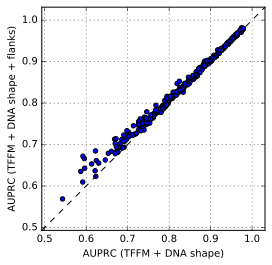

In [35]:
mini = min(min(data["ext_TFFM_dnashape_AUROC"]), min(data["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["ext_TFFM_dnashape_AUROC"]), max(data["TFFM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUROC", x="TFFM_dnashape_AUROC", kind="scatter")
axes.set_ylabel("AUROC (TFFM + DNA shape + flanks)")
axes.set_xlabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

mini = min(min(data["ext_TFFM_dnashape_AUPRC"]), min(data["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["ext_TFFM_dnashape_AUPRC"]), max(data["TFFM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUPRC", x="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_ylabel("AUPRC (TFFM + DNA shape + flanks)")
axes.set_xlabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

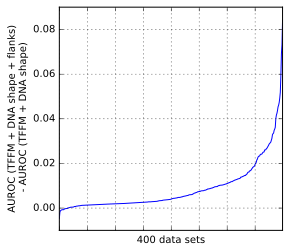

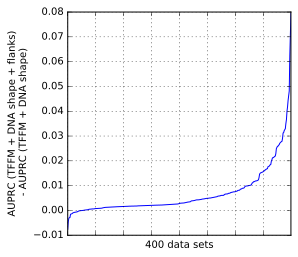

In [36]:
data = data.sort("ext_TFFM_dnashape_AUROC_improvement")
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (TFFM + DNA shape + flanks)\n - AUROC (TFFM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

data = data.sort("ext_TFFM_dnashape_AUPRC_improvement")
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (TFFM + DNA shape + flanks)\n - AUPRC (TFFM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

In [37]:
print 'AUROC difference is > 0.05 for {0:d} data-sets'.format(
    len(data[data.ext_TFFM_dnashape_AUROC_improvement > 0.05]))
print 'AUPRC difference is > 0.05 for {0:d} data-sets'.format(
    len(data[data.ext_TFFM_dnashape_AUPRC_improvement > 0.05]))

AUROC difference is > 0.05 for 5 data-sets
AUPRC difference is > 0.05 for 3 data-sets


## PSSM results on all ChIP-seq experiments

In [38]:
print "PSSM-based classifiers using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_PSSM_dnashape_AUROC"] > data["PSSM_dnashape_AUROC"]]), len(data.dropna()))
print "PSSM-based classifiers using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_PSSM_dnashape_AUPRC"] > data["PSSM_dnashape_AUPRC"]]), len(data.dropna()))

PSSM-based classifiers using the 15bp extension is superior in 388 over 400 cases
PSSM-based classifiers using the 15bp extension is superior in 378 over 400 cases


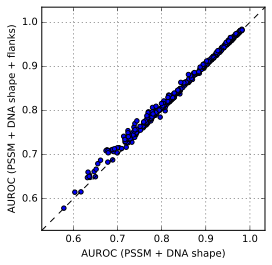

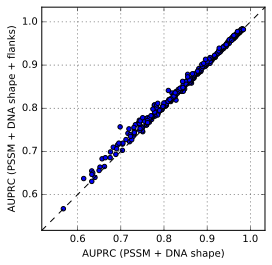

In [39]:
mini = min(min(data["ext_PSSM_dnashape_AUROC"]), min(data["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["ext_PSSM_dnashape_AUROC"]), max(data["PSSM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUROC", x="PSSM_dnashape_AUROC", kind="scatter")
axes.set_ylabel("AUROC (PSSM + DNA shape + flanks)")
axes.set_xlabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUROC_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

mini = min(min(data["ext_PSSM_dnashape_AUPRC"]), min(data["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["ext_PSSM_dnashape_AUPRC"]), max(data["PSSM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUPRC", x="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_ylabel("AUPRC (PSSM + DNA shape + flanks)")
axes.set_xlabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
#savefig("AUPRC_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

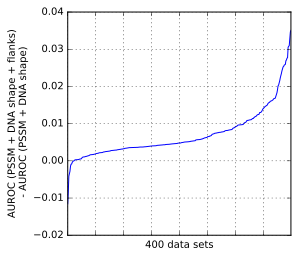

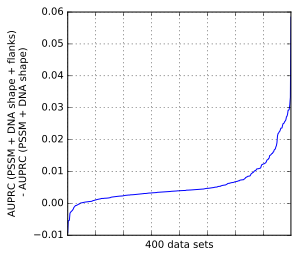

In [40]:
data = data.sort("ext_PSSM_dnashape_AUROC_improvement")
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (PSSM + DNA shape + flanks)\n - AUROC (PSSM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

data = data.sort("ext_PSSM_dnashape_AUPRC_improvement")
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (PSSM + DNA shape + flanks)\n - AUPRC (PSSM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

In [41]:
print 'AUPRC improvement > 0.05 for {0:d} data-sets.'.format(
    len(data[data.ext_PSSM_dnashape_AUPRC_improvement > 0.05]))

AUPRC improvement > 0.05 for 1 data-sets.
